In [1]:
#import modul
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import API 
from tweepy import Cursor
from tweepy import Stream
from textblob import TextBlob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

In [2]:
# Akses key token dan consumer key token untuk menghubungkan twitter dengan jupyter lab
ACCESS_TOKEN = "1334421915549585408-8HocCnFw9QvWCZLXbei8QL5BrwfFi4"
ACCESS_TOKEN_SECRET = "DePvAq20EWinXLyCi82cfPYIedfAamMMRXet5L40e8XWO"
CONSUMER_KEY = "LrSxpWHRWjwa2h8R4SQOZJUIV"
CONSUMER_SECRET = "8d3xWVMKm6LpXDIbZW930I5eiH0kb0jhtNr8pvSHkABm63qPh9"

In [3]:
# Client Twitter
class TwitterClient():
    def __init__(self, user_twitter=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

        self.user_twitter = user_twitter

    def get_twitter_client_api(self):
        return self.twitter_client

    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.user_twitter).items(num_tweets):
            tweets.append(tweet)
        return tweets

    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends, id=self.user_twitter).items(num_friends):
            friend_list.append(friend)
        return friend_list

    def get_home_timeline_tweets(self, num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline, id=self.user_twitter).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets

In [4]:
class TwitterAuthenticator():

    def authenticate_twitter_app(self):
        auth = OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
        auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
        return auth

In [5]:
#Stream Twitter
class TwitterStreamer():
    """
    Class untuk streaming dan pemrosesan tweet langsung.
    """
    def __init__(self):
        pass

    def stream_tweets(self, fetched_tweets_filename, hash_tag_list):
        #Autentifikasi twitter dan koneksi ke twitter streaming API
        listener = StdOutListener(fetched_tweets_filename)
        auth = OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
        auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
        stream = Stream(auth, listener)

        # Untuk memfilter streaming twitter dengan hastag atau kata kunci
        stream.filter(track=hash_tag_list)

In [26]:
# Twitter Stream Listener
import tweepy
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
class TweetAnalyzer():
    """
    Fungsi untuk menganalisis tweet dan mengkategorikan konten-konten dari twitter.
    """

    def clean_tweet(self, tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

    def analyze_sentiment(self, tweet):
        analysis = TextBlob(self.clean_tweet(tweet))
        
        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1

     #Menampilkan hasil kedalam sebuah tabel
    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=["tweets"])
        df["No"] = np.arange(start = 1, stop = len(df)+1)
        df["Id"] = np.array([tweet.id for tweet in tweets])
        df["Date"] = np.array([tweet.created_at for tweet in tweets])
        df["Likes"] = np.array([tweet.favorite_count for tweet in tweets])
        df["Retweets"] = np.array([tweet.retweet_count for tweet in tweets])
        df = df[["No", "tweets", "Id", "Date", "Likes", "Retweets"]]
        return df


if __name__ == '__main__':

    tweet_analyzer = TweetAnalyzer()

    api = tweepy.API(auth)
    
    #streaming data dengan menggunakan hastag RokokNaikRakyatPanik dengan data yg di stream sebanyak 100 
    tweets = api.search(q=['#RokokNaikRakyatPanik'], count=100)

    df = tweet_analyzer.tweets_to_data_frame(tweets)
    df["sentiment"] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df["tweets"]])

In [27]:
# meanmpilkan dataframe hasil streaming dengan hastag RokokNaikRakyatPanik
df.head()

,No,tweets,Id,Date,Likes,Retweets,sentiment
0,1,Bisa bisanya #RokokNaikRakyatPanik https://t.c...,1334711600150822914,2020-12-04 04:10:17,0,0,0
1,2,Naikin aja naikin harga rokoknya\nKarena kami ...,1334711524854657024,2020-12-04 04:09:59,0,0,0
2,3,Merokok atau dirokok \n#RokokNaikRakyatPanik h...,1334711377529749506,2020-12-04 04:09:24,0,0,0
3,4,apalah daya cuma manusia eceran\n#RokokNaikRak...,1334711144502546433,2020-12-04 04:08:29,0,0,0
4,5,"jaman I love 3000,2 batang surya #RokokNaikRa...",1334711099996872705,2020-12-04 04:08:18,0,0,1


In [28]:
#menghitung jumlah sentimen positif, negatif dan netral
positive_count = df[df.sentiment == 1].count()
neutral_count = df[df.sentiment == 0].count()
negative_count = df[df.sentiment == -1].count()
print("Positif: ",positive_count["sentiment"])
print("Negatif: ",negative_count["sentiment"])
print("netral: ", neutral_count["sentiment"])

Positif:  3
Negatif:  1
netral:  96


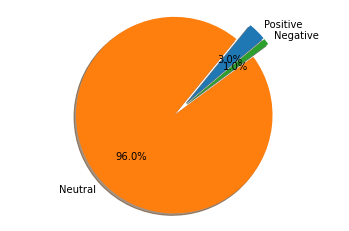

In [35]:
labels = 'Positive', 'Neutral', 'Negative'
sizes = [positive_count["sentiment"], neutral_count["sentiment"], negative_count["sentiment"]]
explode = (0.1, 0.1, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=40)
ax1.axis('equal')

plt.show()